# Predicting KPIs for QQ2: Publications and Open Source Software SEASONALITY


This notebook builds off earlier times series modelling and introduces seasonality and holidays to better predict and visualise the monthly number of publications and monthly open source repositories. 

The input data includes retrospective monthly measurements of each KPI alongside date flags.

In [1]:
##Import Packages
import pandas as pd
from prophet import Prophet
from prophet.plot import plot, add_changepoints_to_plot
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

pd.set_option('display.max_rows', 250)
%matplotlib inline
#print(plt.style.available)

Importing plotly failed. Interactive plots will not work.


In [2]:
##Import data
df = pd.read_csv(r'C:\Users\HollydawnMurray\Documents\KPIs(3).csv',parse_dates = ['Month'])

print('Dataset Shape:', df.shape)
print('Min Obs. Date:',df['Month'].min())
print('Max Obs. Date:',df['Month'].max())
df.head()


Dataset Shape: (45, 5)
Min Obs. Date: 2020-04-01 00:00:00
Max Obs. Date: 2023-12-01 00:00:00


,Month,Publications,Software,First_Month,Last_Month
0,2020-04-01,23.0,6.0,0.0,0.0
1,2020-05-01,42.0,9.0,0.0,0.0
2,2020-06-01,20.0,1.0,0.0,1.0
3,2020-07-01,17.0,2.0,0.0,0.0
4,2020-08-01,18.0,9.0,0.0,0.0


In [3]:
### Generating dates form the date flag in initial dataset - these refer to start and end of academic term###
first_month = df.loc[df['First_Month'] == 1]['Month'].to_list()

last_month = df.loc[df['Last_Month'] == 1]['Month'].to_list()


### Creating a dataframe for each 'holiday' alongside Christmas and Easter periods normally observed in academia ###
First_Month = pd.DataFrame({'holiday': 'first_month',
                                  'ds':  pd.to_datetime(first_month),
                                  'lower_window': 0,
                                  'upper_window': 0 })

Last_Month = pd.DataFrame({'holiday': 'last_month',
                                 'ds':  pd.to_datetime(last_month),
                                 'lower_window': 0,
                                 'upper_window': 0 })

Christmas = pd.DataFrame({'holiday': 'Christmas',
                         'ds': pd.to_datetime(['2020-12-01','2021-01-01', 
                                               '2021-12-01','2022-01-01', 
                                               '2022-12-01', '2023-01-01', '2023-12-01']),
                         'lower_window': 0,
                         'upper_window': 0})

Easter = pd.DataFrame({'holiday': 'Easter',
                         'ds': pd.to_datetime(['2020-04-01','2021-04-01', 
                                               '2022-04-01','2023-04-01']),
                         'lower_window': 0,
                         'upper_window': 0 })

# Create a single holiday dataframe from those above

holidays= pd.concat([First_Month, Last_Month, Christmas, Easter])

holidays.head(5)
holidays.tail(5)


,holiday,ds,lower_window,upper_window
6,Christmas,2023-12-01,0,0
0,Easter,2020-04-01,0,0
1,Easter,2021-04-01,0,0
2,Easter,2022-04-01,0,0
3,Easter,2023-04-01,0,0


In [4]:
#create time stamps and model
cutoff_date = pd.to_datetime('2022-12-01') #last date to include in train
test_end_date = pd.to_datetime('2023-01-01') #last date to include in test

forecast_start_date = pd.to_datetime('2022-12-01') #first date of forecast
forecast_end_date = pd.to_datetime('2023-12-01') #last date of forecast




kpis = ['Publications']


for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['Month'] <= cutoff_date ), ['Month', kpi]]

    df_train = df_train.rename(columns={'Month': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                growth = 'linear',
                seasonality_mode = 'additive',
                daily_seasonality=False,
                weekly_seasonality=False, 
                yearly_seasonality=False, holidays=holidays
                    )
                  
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods=12, freq='MS')#MS is month-start
    forecast = model.predict(future_data)[['ds','yhat_lower', 'yhat','yhat_upper', 'trend']]
df.loc[(df['Month'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

df.tail(10)

Forecasting KPI:  Publications


C:\Users\HollydawnMurray\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


,Month,Publications,Software,First_Month,Last_Month
35,2023-03-01,36.0,NaN,NaN,NaN
36,2023-04-01,32.0,NaN,NaN,NaN
37,2023-05-01,37.0,NaN,NaN,NaN
38,2023-06-01,37.0,NaN,NaN,NaN
39,2023-07-01,38.0,NaN,NaN,NaN
40,2023-08-01,38.0,NaN,NaN,NaN
41,2023-09-01,38.0,NaN,NaN,NaN
42,2023-10-01,39.0,NaN,NaN,NaN
43,2023-11-01,39.0,NaN,NaN,NaN
44,2023-12-01,37.0,NaN,NaN,NaN


,Month,Publications,yhat_lower,yhat,yhat_upper,trend
40,2023-08-01,38.0,25.640580,38.551786,51.690523,38.551786
41,2023-09-01,38.0,26.908777,38.956601,51.756528,38.956601
42,2023-10-01,39.0,26.769908,39.348358,52.559556,39.348358
43,2023-11-01,39.0,27.602784,39.753173,53.430770,39.753173
44,2023-12-01,37.0,25.628444,37.345118,50.555551,40.144929


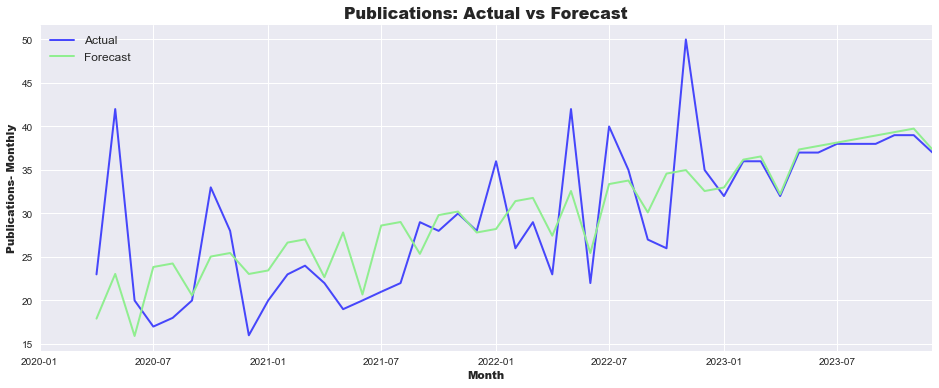

In [5]:
# Join Original Dataset With Forecast
combined_df = df.join(forecast, how = 'outer')

plt.figure(figsize=(16,6))
plt.plot(combined_df['Month'], combined_df['Publications'], 
         linewidth=2, color = 'blue' ,alpha = 0.7, label = 'Actual')
plt.plot(combined_df['Month'], combined_df['yhat'], 
         linewidth=2, color = 'lightgreen', label = 'Forecast')


plt.title('Publications: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Month', fontweight='heavy')
plt.ylabel('Publications- Monthly', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2023-12-01'))
combined_df[['Month', 'Publications', 'yhat_lower' , 'yhat', 'yhat_upper' ,'trend']].tail()

(18262.0, 19692.0)

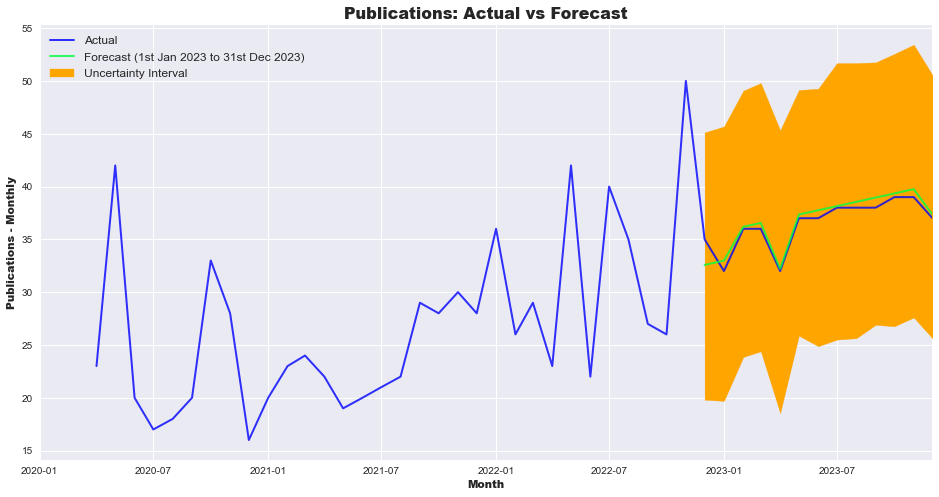

In [6]:
forecast_adj = forecast.loc[forecast['ds'] >=forecast_start_date, ['yhat_lower','yhat','yhat_upper']]
combined_df_adj = df.join(forecast_adj, how = 'outer')

plt.figure(figsize=(16,8))
plt.plot(combined_df_adj['Month'], combined_df_adj['Publications'], 
         linewidth=2, color = 'blue' ,alpha = 0.8, label = 'Actual')
plt.plot(combined_df_adj['Month'], combined_df_adj['yhat'], 
         linewidth=2, color = '#00ff41', alpha = 0.8 , label = 'Forecast (1st Jan 2023 to 31st Dec 2023)')
plt.fill_between(combined_df_adj['Month'], combined_df_adj['yhat_upper'], combined_df_adj['yhat_lower'], 
                 color='orange', label = 'Uncertainty Interval')

plt.title('Publications: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Month', fontweight='heavy')
plt.ylabel('Publications - Monthly', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2023-12-01'))

In [7]:
combined_df_test = combined_df.loc[(combined_df['Month'] > cutoff_date)
                                    & (combined_df['Month'] <= test_end_date )]


mape =(np.mean(np.abs(combined_df_test['Publications']-combined_df_test['yhat'])/
               np.abs(combined_df_test['Publications'])))*100
print('MAPE:',  mape)

MAPE: 3.073633872353998


In [8]:
kpis = ['Publications']


for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['Month'] <= cutoff_date ), ['Month', kpi]]

    df_train = df_train.rename(columns={'Month': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                growth = 'linear',
                seasonality_mode = 'multiplicative',
                daily_seasonality=False,
                weekly_seasonality=False, 
                yearly_seasonality=False).add_seasonality(
                    name = 'monthly',
                    period = 30.5,
                    fourier_order = 14,
                    prior_scale = 15
                    ).add_seasonality(
                    name = 'yearly',
                    period = 365.25,
                    fourier_order = 10,
                    prior_scale = 15
                    ) #exploring further seasonal affects of month and year
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods=12, freq='MS')#MS is month-start
    forecast = model.predict(future_data)[['ds','yhat_lower', 'yhat','yhat_upper', 'trend']]
df.loc[(df['Month'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

combined_df_test = combined_df.loc[(combined_df['Month'] > cutoff_date)
                                    & (combined_df['Month'] <= test_end_date )]


mape =(np.mean(np.abs(combined_df_test['Publications']-combined_df_test['yhat'])/
               np.abs(combined_df_test['Publications'])))*100
print('MAPE:',  mape)


Forecasting KPI:  Publications
MAPE: 3.073633872353998


In [9]:
import sys
!{sys.executable} -m pip install watermark
%load_ext watermark 
%watermark 
%watermark --iversions 

Last updated: 2023-01-11T09:50:51.124738+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores   : 8
Architecture: 64bit

sys       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.3.4
numpy     : 1.23.5
pandas    : 1.2.4



In [10]:
import os
os.getcwd()
os.chdir('C:\\Users\\HollydawnMurray\\downloads')

In [11]:
#naming files with a timestamp
import time

TodaysDate = time.strftime("%d-%m-%Y")
KPIsfilename = "seasonalforecast_KPIs"+ TodaysDate +".xlsx"

combined_df.to_excel(KPIsfilename, index=False)  #this has created an xls file in the same directory you are working in (check downloads)


PermissionError: [Errno 13] Permission denied: 'forecast_KPIs11-01-2023.xlsx'